In [3]:
# 📌 Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 📌 Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [6]:
# 📌 Step 3: Load cleaned data from Drive
cleaned_data = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')

In [7]:
# 📌 Step 4: Aggregate to Daily Sales
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'])
daily_sales = cleaned_data.groupby('Date')['כמות'].sum().reset_index()
daily_sales.columns = ['Date', 'Total_Quantity']
true_values = daily_sales['Total_Quantity'].values

In [8]:
# 📌 Step 5: Create Baseline Forecasts
mean_forecast = np.full_like(true_values, fill_value=np.mean(true_values))
naive_forecast = np.roll(true_values, shift=1)
naive_forecast[0] = true_values[0]
moving_avg_forecast = pd.Series(true_values).rolling(window=7, min_periods=1).mean().shift(1).fillna(method='bfill').values

<ipython-input-8-e864db59b4fd>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  moving_avg_forecast = pd.Series(true_values).rolling(window=7, min_periods=1).mean().shift(1).fillna(method='bfill').values


In [9]:
# 📌 Step 6: Evaluation Function
def evaluate_forecast(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return round(mae, 2), round(rmse, 2), round(mape, 2)

In [10]:
# 📌 Step 7: Evaluate All Baselines
results = {
    'Baseline Model': ['Mean Forecast', 'Naïve (Last Day)', '7-Day Moving Average'],
    'MAE': [],
    'RMSE': [],
    'MAPE (%)': []
}

for pred in [mean_forecast, naive_forecast, moving_avg_forecast]:
    mae, rmse, mape = evaluate_forecast(true_values, pred)
    results['MAE'].append(mae)
    results['RMSE'].append(rmse)
    results['MAPE (%)'].append(mape)

results_df = pd.DataFrame(results)
results_df

,Baseline Model,MAE,RMSE,MAPE (%)
0,Mean Forecast,144.22,191.79,62.74
1,Naïve (Last Day),194.39,257.66,87.99
2,7-Day Moving Average,144.62,192.97,63.95


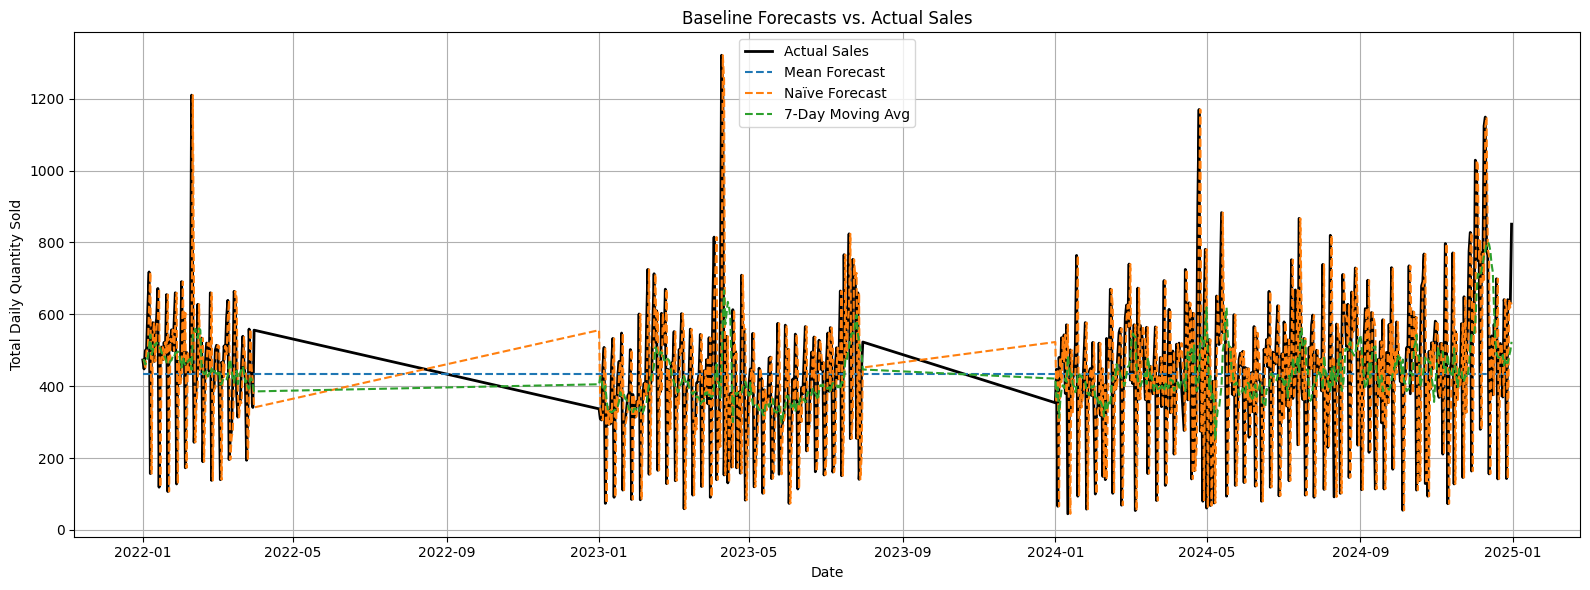

In [11]:
# 📊 Plot Forecasts vs. Actual
plt.figure(figsize=(16, 6))
plt.plot(daily_sales['Date'], true_values, label='Actual Sales', color='black', linewidth=2)
plt.plot(daily_sales['Date'], mean_forecast, label='Mean Forecast', linestyle='--')
plt.plot(daily_sales['Date'], naive_forecast, label='Naïve Forecast', linestyle='--')
plt.plot(daily_sales['Date'], moving_avg_forecast, label='7-Day Moving Avg', linestyle='--')

plt.title('Baseline Forecasts vs. Actual Sales')
plt.xlabel('Date')
plt.ylabel('Total Daily Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# ✅ Step 1: Identify the best baseline based on lowest MAPE
best_row = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_baseline_name = best_row['Baseline Model']
best_mape = best_row['MAPE (%)']
best_rmse = best_row['RMSE']
best_mae = best_row['MAE']

# Get predicted values for best baseline
if best_baseline_name == 'Mean Forecast':
    y_pred = mean_forecast
elif best_baseline_name == 'Naïve (Last Day)':
    y_pred = naive_forecast
else:
    y_pred = moving_avg_forecast

# True values for all baselines
y_true = true_values
n = len(y_true)
p = 1  # One predictor

# Compute R² and Adjusted R²
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# ✅ Print Summary
print(f"📌 Best Baseline Model: {best_baseline_name}")
print(f"  → MAE: {best_mae}")
print(f"  → RMSE: {best_rmse}")
print(f"  → MAPE: {best_mape:.2f}%")
print(f"  → R²: {r2:.6f}")
print(f"  → Adjusted R²: {adjusted_r2:.6f}")


📌 Best Baseline Model: Mean Forecast
  → MAE: 144.22
  → RMSE: 191.79
  → MAPE: 62.74%
  → R²: -0.000012
  → Adjusted R²: -0.001548


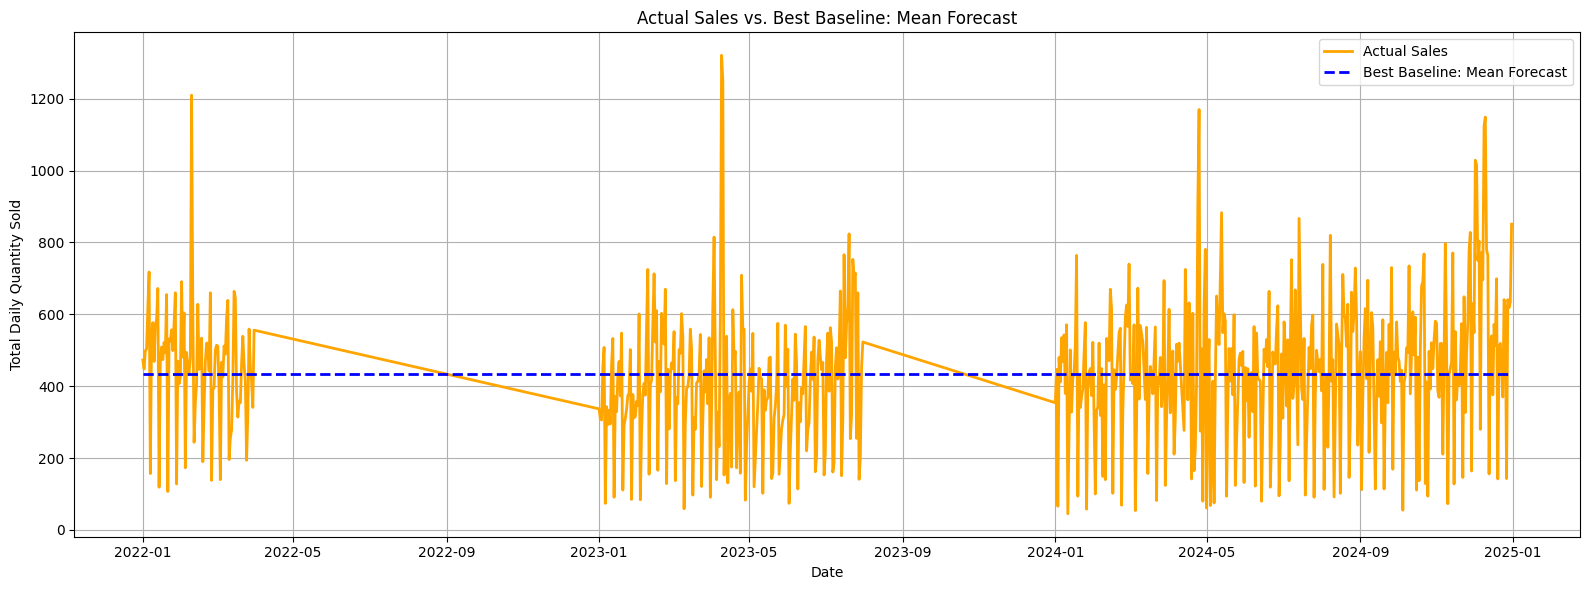

In [15]:
# 📊 Plot only the best baseline vs. actual sales
import matplotlib.pyplot as plt

# Re-identify best baseline (if needed)
best_row = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_baseline_name = best_row['Baseline Model']

# Get forecast and color
if best_baseline_name == 'Mean Forecast':
    best_forecast = mean_forecast
    best_color = 'blue'
elif best_baseline_name == 'Naïve (Last Day)':
    best_forecast = naive_forecast
    best_color = 'orange'
else:
    best_forecast = moving_avg_forecast
    best_color = 'green'

# Plot
plt.figure(figsize=(16, 6))
plt.plot(daily_sales['Date'], true_values, label='Actual Sales', color='orange', linewidth=2)
plt.plot(daily_sales['Date'], best_forecast, label=f'Best Baseline: {best_baseline_name}',
         color=best_color, linestyle='--', linewidth=2)

plt.title(f'Actual Sales vs. Best Baseline: {best_baseline_name}')
plt.xlabel('Date')
plt.ylabel('Total Daily Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
